In [14]:
#SECTION 0: DATA PREPARATION

#Import base libraries for this task
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [15]:
#Import libraries for testing and validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

## SECTION 1: Data Preparation & Cleaning

### Summary of Preparations Below

To properly clean the dataset for use in various models I perform the following transformations:

- Dropping Unused Attributes
- Feature Scaling
- Separating Labels from Remaining Attributes
- Encoding Categorical Values with OneHotEncoding
- Imputing missing values


In [3]:
titanic_copy = pd.read_csv('./datasets/train.csv')
titanic_copy.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#Read in the full set of training data
titanic_full = pd.read_csv('./datasets/train.csv')

#Remove the two missing Embarked rows
titanic_full = titanic_full[titanic_full.Embarked.notnull()]

#Split the full training dataset into a training subset and test set
titanic_train, titanic_test = train_test_split(titanic_full, 
                            test_size=0.2, random_state=10)

In [5]:
#Create copies of the data to be cleaned
titanic_train_cleaned = titanic_train.copy()
titanic_test_cleaned = titanic_test.copy()

#Drop the attributes that won't be used for pedictions
titanic_train_cleaned = titanic_train_cleaned.drop(['Name', 'PassengerId', 'Ticket'], axis=1)
titanic_test_cleaned = titanic_test_cleaned.drop(['Name', 'PassengerId', 'Ticket'], axis=1)

titanic_train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 711 entries, 57 to 266
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  711 non-null    int64  
 1   Pclass    711 non-null    int64  
 2   Sex       711 non-null    object 
 3   Age       577 non-null    float64
 4   SibSp     711 non-null    int64  
 5   Parch     711 non-null    int64  
 6   Fare      711 non-null    float64
 7   Cabin     160 non-null    object 
 8   Embarked  711 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 55.5+ KB


In [6]:
#Map cabin values s.t. not having a cabin == 0 (False) and having a cabin == 1 (True)
titanic_train_cleaned['Cabin']= np.where(titanic_train_cleaned['Cabin'].isnull(), 0, 1)
titanic_test_cleaned['Cabin']= np.where(titanic_test_cleaned['Cabin'].isnull(), 0, 1)

### Correlation

Due to the high correlation of the cabin attribute and whether or not someone survived,
I decided to keep this attribute for model training.

I did find that this attribute doesn't affect the test performance of the models by a considerable amount in most cases, but did improve classification for Naive-Bayes.

In [35]:
#Create a correlation matrix between some attributes and the 'Survived' target attribute
corr_matrix = titanic_train_cleaned.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived    1.000000
Cabin       0.280849
Fare        0.229058
Parch       0.076900
SibSp      -0.028415
Age        -0.108210
Pclass     -0.311321
Name: Survived, dtype: float64

In [56]:
#Divide the total set of passengers into subsets based on whether or not they survived
#and whether or not they had a cabin
survived_cabin = len(titanic_train_cleaned[(titanic_train_cleaned.Cabin == 1) &
                                       (titanic_train_cleaned.Survived == 1)])

died_cabin = len(titanic_train_cleaned[(titanic_train_cleaned.Cabin == 1) &
                                       (titanic_train_cleaned.Survived == 0)])

survived_cabinless = len(titanic_train_cleaned[(titanic_train_cleaned.Cabin == 0) &
                                       (titanic_train_cleaned.Survived == 1)])

died_cabinless = len(titanic_train_cleaned[(titanic_train_cleaned.Cabin == 0) & 
                                        (titanic_train_cleaned.Survived == 0)])


total_cabin = survived_cabin + died_cabin
total_cabinless = survived_cabinless + died_cabinless

print("Summary survival rates with and without a cabin:")
print("Out of " + str(total_cabin) + " passengers with a cabin, " + "{:.4f}".format((survived_cabin / total_cabin) * 100) + "% survived.")
print("Out of " + str(total_cabinless) + " passengers without a cabin, " + "{:.4f}".format((survived_cabinless / total_cabinless) * 100) + "% survived.")

Summary survival rates with and without a cabin:
Out of 160 passengers with a cabin, 64.3750% survived.
Out of 551 passengers without a cabin, 31.5789% survived.


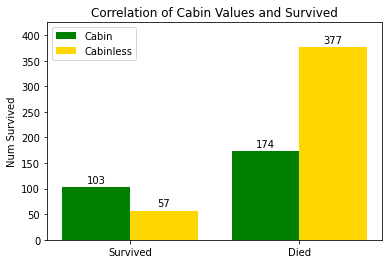

In [77]:
#Construct a Bar Graph 
labels = ['Survived', 'Died']
survived_counts = [survived_cabin, survived_cabinless]
died_counts = [died_cabin, died_cabinless]

x = np.arange(2)
bar_width = 0.4

survived_bars = plt.bar(x - bar_width/2, survived_counts, bar_width, label='Cabin', color='green')
died_bars = plt.bar(x + bar_width/2, died_counts, bar_width, label='Cabinless', color='gold')

plt.title('Correlation of Cabin Values and Survived')
plt.ylabel('Num Survived')
plt.ylim(0,425)
plt.xticks(x, labels)
plt.legend()


plt.bar_label(survived_bars, padding=2)
plt.bar_label(died_bars, padding=2)
plt.show()

In [36]:
#Remove the labels from the training set
train_labels = titanic_train_cleaned["Survived"].copy()
titanic_train_cleaned = titanic_train_cleaned.drop("Survived", axis=1)

#Remove the labels from the test set
test_labels = titanic_test_cleaned["Survived"].copy()
titanic_test_cleaned = titanic_test_cleaned.drop("Survived", axis=1)

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

#Get the full list of columns in the titanic training set
full_attributes = titanic_train_cleaned.columns

#Gather the attributes to be transformed
num_attributes = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
cat_attributes = ['Sex','Embarked','Cabin']

#Create a pipeline to clean the numerical attributes
#Missing age values will be imputed using the IterativeImputer
#All numerical values will be scaled to have a similar scale
num_pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler())
])

#Create a full pipeline to clean the numerical and categorical attributes
#Categoricial attribute values will be encoded without relationship (Non-Ordinal encoding)
data_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attributes),
    ('cat', OneHotEncoder(), cat_attributes),
], remainder='drop')


In [38]:
#Apply the data cleaning transformations to the training and test data
titanic_train_cleaned = data_pipeline.fit_transform(titanic_train_cleaned)
titanic_test_cleaned = data_pipeline.fit_transform(titanic_test_cleaned)

----
----
## SECTION 2: Tree Models (Training & Testing)

In this section I use various Tree model classifiers on the dataset. In-particular, I use:

- A Decision Tree Classifier
- A Random Forest Classifier
- Gradient-Boosted Trees (for Classification)

This section also introduces my use of hyperparameter tuning. This is done in an effort to get the best possible
attributes for classification.

### SECTION 2A: Decision Tree Model Training

A basic Decision Tree Classifier is used here. 

For Hyperparameter tuning, I adjust:
- max_features: The maximum number of features to consider for splitting
- max_depth: The maximum allowable depth of the tree
- splitter: Whether or not the attribute to split with should be the 'best' attribute or a 'random' one

In [87]:
#Create a DecisionTree Classifier with default parameters
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(random_state=10)
tree_clf.fit(titanic_train_cleaned, train_labels)

#Perform cross-validation on the training dataset
tree_pred_score = cross_val_score(tree_clf, titanic_train_cleaned, train_labels, scoring="accuracy").mean()
print("Decision Tree Prediction Score: " + "{:.6f}".format(tree_pred_score))

Decision Tree Prediction Score: 0.759490


In [88]:
#Perform Grid-Search using the specified HyperParameters to find the best combination
from sklearn.model_selection import GridSearchCV

#Create the set of parameters to experiment with
param_grid = [{'splitter': ['best', 'random'], 'max_features': [2,4,6], 'max_depth': [2, 4, 6]}]

#Create the GridSearch Classifier and fit the data with each model created
tree_grid_search = GridSearchCV(tree_clf, param_grid, cv=10, scoring='accuracy', return_train_score=True)
tree_grid_search.fit(titanic_train_cleaned, train_labels)

#Return the best set of parameters
print("Best parameters found for the decision tree are:")
tree_grid_search.best_params_

Best parameters found for the decision tree are:


{'max_depth': 6, 'max_features': 6, 'splitter': 'best'}

In [89]:
#Evaluate the performance of the best estimator using the parameters specified

#Get the best estimator classifier from the GridSearch object
tree_tuned_clf = tree_grid_search.best_estimator_

#Get the best score produced
tree_tuned_pred_score = tree_grid_search.best_score_

print("Tuned Decision Tree Validation Score: " + "{:.6f}".format(tree_tuned_pred_score))

Tuned Decision Tree Validation Score: 0.808783


____
### SECTION 2B: Random Forest Model Training

A random forest classifier is used here.


For hyperparameter tuning, I adjust:
- n_estimators: The number of individual decision trees to use.
- max_features: The maximum number of features to consider for splitting.
- max_depth: The maximum allowable depth of the tree.
- bootstrap: Whether or not to use bootstrapping (bagging) or paging for selecting samples.

In [90]:
#Create a basic RandomForestClassifier with default parameters
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=10)

#Fit the model to the data and evaluate its accuracy
forest_clf.fit(titanic_train_cleaned, train_labels)
forest_pred_score = cross_val_score(forest_clf, titanic_train_cleaned, train_labels, scoring="accuracy").mean()
print("Random Forest Validation Score: " + "{:.6f}".format(forest_pred_score))

Random Forest Validation Score: 0.800305


In [91]:
#Perform Grid-Search using the specified HyperParameters to find the best combination

#Create the sets of parameters
param_grid = [
    {'n_estimators': [3,10,30], 'max_features': [2,4,6], 'max_depth': [2, 4, 6]}, 
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,3,4], 'max_depth': [2, 4, 6]}
]

#Create the GridSearch Classifier and fit the data with each model created
forest_grid_search = GridSearchCV(forest_clf, param_grid, cv=10, scoring='accuracy', 
                                  return_train_score=True)

forest_grid_search.fit(titanic_train_cleaned, train_labels)

#Return the best set of parameters
print("Best parameters found for the random forest are:")
forest_grid_search.best_params_

Best parameters found for the random forest are:


{'bootstrap': False, 'max_depth': 6, 'max_features': 2, 'n_estimators': 3}

In [92]:
#Evaluate the performance of the best estimator using the parameters specified

#Get the best estimator classifier from the GridSearch object
forest_tuned_clf = forest_grid_search.best_estimator_

forest_tuned_pred_score = forest_grid_search.best_score_

print("Tuned Random Forest Validation Score: " + "{:.6f}".format(forest_tuned_pred_score))

Tuned Random Forest Validation Score: 0.825626


----
### SECTION 2C: Boosting Methods Using Trees

A gradient boosting tree classifier is used here.

In [98]:
#Create a classifier that uses regression trees in Gradient boosting for classification
from sklearn.ensemble import GradientBoostingClassifier

gb_tree_clf = GradientBoostingClassifier(random_state=10)
gb_tree_clf.fit(titanic_train_cleaned, train_labels)

gb_tree_pred_score = cross_val_score(gb_tree_clf, titanic_train_cleaned, train_labels, 
                            scoring="accuracy").mean()

print("Gradient Boosting Tree Validation Score: " + "{:.6f}".format(gb_tree_pred_score))

Gradient Boosting Tree Validation Score: 0.822762


In [99]:
#Summary
print("Summary Classification Validation Scores for Trees")
print("Decision Tree Score: " + "{:.6f}".format(tree_pred_score))
print("Tuned Decision Tree Score: " + "{:.6f}".format(tree_tuned_pred_score))
print("Random Forest Score: " + "{:.6f}".format(forest_pred_score))
print("Tuned Random Forest Score: " + "{:.6f}".format(forest_tuned_pred_score))
print("Gradient Boosting Tree Score: " + "{:.6f}".format(gb_tree_pred_score))

Summary Classification Validation Scores for Trees
Decision Tree Score: 0.759490
Tuned Decision Tree Score: 0.808783
Random Forest Score: 0.800305
Tuned Random Forest Score: 0.825626
Gradient Boosting Tree Score: 0.822762


### Comparing Training & Validation Performance

- The Decision Tree had the weakest performance.
- The tuned Decision Tree had substantially better performance (Likely due to overfitting).
- The Random Forest out-performed the decision tree.
- The tuned Random Forest has substantially better performance (Likely due to overfitting).
- The Gradient Boosted Tree has comparable performance to the tuned Random Forest.

My assumptions for the tuned models with more generous features will have to be evaluated in the testing stage to come.

### Evaluating Confusion Metrics

To get a better understanding of how samples are being misclassified, I computed the confusion matrix for a few of the Decision Tree classifiers.

In [100]:
#Get the number of correct and incorrect classifications using the DecisionTree and RandomForest classifiers
tree_tuned_labels = cross_val_predict(tree_tuned_clf, titanic_train_cleaned, train_labels, cv=10)
forest_tuned_labels = cross_val_predict(forest_tuned_clf, titanic_train_cleaned, train_labels, cv=10)

#Compute the Confusion Matrix for each
tree_conf_matrix = confusion_matrix(train_labels, tree_tuned_labels)
forest_conf_matrix = confusion_matrix(train_labels, forest_tuned_labels) 

print("Tuned Decision Tree False Positives: " + str(tree_conf_matrix[0][1]) + "/" + str(len(train_labels)))
print("Tuned Decision Tree False Negatives: " + str(tree_conf_matrix[1][0]) + "/" + str(len(train_labels)) + "\n")

print("Tuned Random Forest False Positives: " + str(forest_conf_matrix[0][1]) + "/" + str(len(train_labels)))
print("Tuned Random Forest False Negatives: " + str(forest_conf_matrix[1][0]) + "/" + str(len(train_labels)))

Tuned Decision Tree False Positives: 39/711
Tuned Decision Tree False Negatives: 97/711

Tuned Random Forest False Positives: 32/711
Tuned Random Forest False Negatives: 92/711


### Interpreting the Confusion Metrics

As can be seen in these metrics, both the tree and forest classifiers are heavily underestimating the actual number of survivors based on the input features. This can be slightly seen from earlier due to the negative correlation the selected features for evaluation had on the 'Survived' property. Namely, SibSp, Age, and Pclass.

-------
### SECTION 2D: Measuring Test Performance

The test scores using all of the tree models established previously are evaluated here.

In [101]:
#TEST SET

def getTestScore(model):
    return cross_val_score(model, titanic_test_cleaned, test_labels, scoring="accuracy").mean()
    
tree_test_score = getTestScore(tree_clf)
tree_tuned_test_score = getTestScore(tree_tuned_clf)
forest_test_score = getTestScore(forest_clf)
forest_tuned_test_score = getTestScore(forest_tuned_clf)
gb_test_score = getTestScore(gb_tree_clf)

print("Summary Test Classification Scores for Tree Models")
print("Decision Tree Score: " + "{:.6f}".format(tree_test_score))
print("Tuned Decision Tree Score: " + "{:.6f}".format(tree_tuned_test_score))
print("Random Forest Score: " + "{:.6f}".format(forest_test_score))
print("Tuned Random Forest Score: " + "{:.6f}".format(forest_tuned_test_score))
print("Gradient Boosting Tree Score: " + "{:.6f}".format(gb_test_score))

Summary Test Classification Scores for Tree Models
Decision Tree Score: 0.764127
Tuned Decision Tree Score: 0.786508
Random Forest Score: 0.792222
Tuned Random Forest Score: 0.775556
Gradient Boosting Tree Score: 0.792222


#### Reflections on Test Scores

From the test scores here, all of the scores are lower than those found on the training set with the exception of the decision tree. This is likely due to the remaining models having more features to work with, allowing them to overfit the data. Gradient Boosting is especially prone to this, and had the biggest drop.

In this regard, the original decision tree seemed to have better generalization capabilities, as its performance is slightly better than that found with the training data.

----
----
## SECTION 3: Naive Bayes (Training & Testing)

In this section, the Gaussian Naive Bayes estimator for classification is evaluated in training and testing.

### Section 3A: Naive Bayes Model Training

In [39]:
from sklearn.naive_bayes import GaussianNB

#Instantiate a Gaussian Naive-Bayes classifier and fit it to the data
gaussian_nb_clf = GaussianNB()
gaussian_nb_clf.fit(titanic_train_cleaned, train_labels)

#Perform cross-validation to evaluate its predictions on the data
gaussian_nb_pred_score = cross_val_score(gaussian_nb_clf, titanic_train_cleaned, train_labels, scoring="accuracy").mean()
print("Gaussian Naive Bayes Score: " + "{:.6f}".format(gaussian_nb_pred_score))

Gaussian Naive Bayes Score: 0.759470


---
### Section 3B: Naive Bayes Test Performance

In [40]:
#Evaluate the Estimator's prediction ability on the test set
gaussian_nb_test_score = cross_val_score(gaussian_nb_clf, titanic_test_cleaned, test_labels, scoring="accuracy").mean()
print("Gaussian Naive Bayes Test Score: " + "{:.6f}".format(gaussian_nb_test_score))

Gaussian Naive Bayes Test Score: 0.826190


### Reflections on Performance

Interestingly enough, the test perfomance score is significantly higher than the validation score in training. My best guess for what's happening here is that Naive Bayes is better at predicting the test data due to its smaller size.

____
____
## Section 4: Neural Network (Training & Testing)

This section uses a small deep neural network for predicting on the dataset.

A neural network with randomly selected parameters is evaluated first before experimenting with hyperparameter
fine tuning to try and get better results.

### Section 4A: Neural Network Training

In [108]:
import tensorflow as tf
from tensorflow import keras

from keras import models
from keras import layers

import numpy as np

In [109]:
#Create a copy of the Titanic Training data so that it can be flattened without affecting the original data
titanic_train_flat = titanic_train_cleaned.copy()

In [110]:
#Define the Neural Network Build function
#This function creates a Deep Sequential neural network with a Flattening layer, two Dense (Fully-connected) layers,
#and a final decision layer using the sigmoid activation function
def create_neural_net():
    model_nn = models.Sequential()
    model_nn.add(layers.Flatten())
    model_nn.add(layers.Dense(32, activation='relu'))
    model_nn.add(layers.Dense(16, activation='relu'))
    model_nn.add(layers.Dense(1, activation='sigmoid'))
    
    #Configure the network to use an RMSProp optimization function
    #The network measures loss using Binary Cross-entropy
    #The network measures its success in accuracy (ratio of correctly labeled data)
    model_nn.compile(optimizer='rmsprop', loss='binary_crossentropy', 
              metrics=['accuracy'])
    
    return model_nn

In [112]:
titanic_nn = create_neural_net()

In [114]:
#Train the Neural Network using the training data and validate it with a validation split of 25%
#The history object stores loss and accuracy for every epoch
history = titanic_nn.fit(titanic_train_flat, train_labels, epochs=20,
                   batch_size=32, validation_split=0.25, verbose=0)

#Get the stored array values in the History object
history_dict = history.history
loss_values = history_dict['loss'] #Training loss at each epoch
val_loss_values = history_dict['val_loss'] #Validation loss at each epoch
acc_values = history_dict['accuracy'] #Accuracy at each epoch

#Get the final epoch values
print("Final epoch training loss: " + "{:.6f}".format(loss_values[len(loss_values)-1]))
print("Final epoch validation loss: " + "{:.6f}".format(val_loss_values[len(val_loss_values)-1]))
print("Final epoch accuracy: " + "{:.6f}".format(acc_values[len(acc_values)-1]))

Final epoch training loss: 0.443238
Final epoch validation loss: 0.408258
Final epoch accuracy: 0.814259


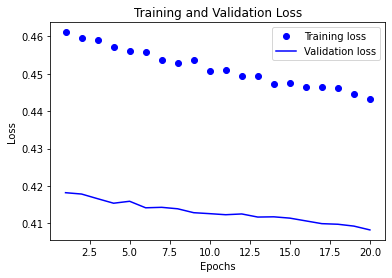

In [115]:
#Create a plot that maps the training and validation loss per epoch

#Plot the training and validation loss at each epoch
epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label="Validation loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

The graph above gives us a rough idea of where the algorithm peaks in its epochs of training. The best epoch and score are explicitly stated below.

In [116]:
#Get the best epoch accuracy score
best_epoch_index = np.argmax(history.history['accuracy'])
best_epoch_score = history.history['accuracy'][best_epoch_index]

print("The best epoch was " + str(best_epoch_index) + " with a score of: " + "{:.6f}".format(best_epoch_score))

The best epoch was 19 with a score of: 0.814259


___
### Section 4B: Neural Network Hyperparameter Tuning

In the section below, the KerasClassifier Wrapper Class is used to create a Neural Network
estimator that can have its hyperparameters tuned using scikit-learn's built-in methods.

In [117]:
from keras.wrappers.scikit_learn import KerasClassifier


titanic_nn_wrapped = KerasClassifier(build_fn=create_neural_net, verbose=0)

In [118]:
#Investigate the best hyperparameter values to the neural network using GridSearch
batch_sizes = [12, 24, 32]
epochs = [5, 10, 20]

param_dict = dict(batch_size=batch_sizes, epochs=epochs)

titanic_nn_grid = GridSearchCV(estimator=titanic_nn_wrapped, param_grid=param_dict, cv=5, scoring='accuracy', n_jobs=1)
titanic_nn_grid.fit(titanic_train_flat, train_labels)

nn_best_params = titanic_nn_grid.best_params_

print("The best parameters for the neural network are: ")
print(nn_best_params)

The best parameters for the neural network are: 
{'batch_size': 12, 'epochs': 20}


In [119]:
#Create a neural network using the 
titanic_nn_tuned = create_neural_net()

history = titanic_nn_tuned.fit(titanic_train_flat, train_labels, epochs=nn_best_params['epochs'],
                   batch_size=nn_best_params['batch_size'], validation_split=0.25, verbose=0)

#Get the best epoch accuracy score for the tuned neural network
best_epoch_index = np.argmax(history.history['accuracy'])
best_epoch_score = history.history['accuracy'][best_epoch_index]

print("For the Hyperparameter tuned neural network, ")
print("The best epoch was " + str(best_epoch_index) + " with a score of: " + "{:.6f}".format(best_epoch_score))

For the Hyperparameter tuned neural network, 
The best epoch was 15 with a score of: 0.808630


### Section 4C: Neural Network Test Performance

Below, both neural networks are evaluated for their accuracy on the test set.

In [120]:
#Compute the test accuracy of the neural network
network_results = titanic_nn.evaluate(titanic_test_cleaned, test_labels)
print("Neural Network Test Score " + "{:.6f}".format(network_results[1]))

6/6 [==============================] - 0s 2ms/step - loss: 0.4010 - accuracy: 0.8315
Neural Network Test Score 0.831461


In [121]:
#Compute the test accuracy of the neural network
results = titanic_nn_tuned.evaluate(titanic_test_cleaned, test_labels)
print("Hyper Parameter Tuned Neural Network Test Score " + "{:.6f}".format(results[1]))

6/6 [==============================] - 0s 2ms/step - loss: 0.4011 - accuracy: 0.8146
Hyper Parameter Tuned Neural Network Test Score 0.814607


___
___
## Section 5: Experiments in Clustering

In this section I attempt to use clustering techniques to improve the performance of a few classifiers to see if any new trends could be discovered. This was done in an attempt to see if the clustering as preprocessing had any major effects.

A Grid_Search for an optimal number of initial clusters is used for the k_means classifier.

In [85]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=10)

In [155]:
#Create a pipeline using KMeans clustering and Gaussian NB for classification

num_clusters = range(2,10)
param_grid = dict(kmeans__n_clusters=num_clusters)

#Create a Pipeline that applies KMeans to the dataset and then runs Gaussian NB for classification
gaussian_cluster_pipeline = Pipeline([
    ("kmeans", kmeans),
    ("gaussian", gaussian_nb_clf)
])

gaussian_cluster_grid = GridSearchCV(gaussian_cluster_pipeline, param_grid, verbose=0)
gaussian_cluster_grid.fit(titanic_train_cleaned, train_labels)
print("The best cluster size for Kmeans is: " + str(gaussian_cluster_grid.best_params_['kmeans__n_clusters']))

gaussian_cluster_clf = gaussian_cluster_grid.best_estimator_

The best cluster size for Kmeans is: 2


In [156]:
#Create a pipeline using KMeans clustering and a Random Forest for classification

forest_cluster_pipeline = Pipeline([
    ("kmeans", kmeans),
    ("forest", forest_tuned_clf)
])

forest_cluster_grid = GridSearchCV(forest_cluster_pipeline, param_grid, verbose=0)
forest_cluster_grid.fit(titanic_train_cleaned, train_labels)
print("The best cluster size for Kmeans is: " + str(forest_cluster_grid.best_params_['kmeans__n_clusters']))

forest_cluster_clf = forest_cluster_grid.best_estimator_

The best cluster size for Kmeans is: 4


In [157]:
#Run each of these classifiers on the test data
gaussian_cluster_test_score = cross_val_score(gaussian_cluster_clf, titanic_test_cleaned, 
                                    test_labels, scoring="accuracy").mean()

forest_cluster_test_score = cross_val_score(forest_cluster_clf, titanic_test_cleaned, 
                                    test_labels, scoring="accuracy").mean()

### Comparing Performance Metrics

Below, the compared performance of the Gaussian NB and Random Forest Classifier on the training and test sets with and without clustering as preprocessing is compared.

In [158]:
print("Gaussian Naive Bayes without clustering validation score: " + "{:.6f}".format(gaussian_nb_pred_score))
print("Gaussian Naive Bayes with clustering validation score: " + "{:.6f}".format(gaussian_cluster.best_score_))

print("Gaussian Naive Bayes without clustering test score: " + "{:.6f}".format(gaussian_nb_test_score))
print("Gaussian Naive Bayes with clustering test score: " + "{:.6f}".format(gaussian_cluster_test_score))

Gaussian Naive Bayes without clustering validation score: 0.759470
Gaussian Naive Bayes with clustering validation score: 0.777741
Gaussian Naive Bayes without clustering test score: 0.826190
Gaussian Naive Bayes with clustering test score: 0.775556


In [159]:
print("Random Forest without clustering validation score: " + "{:.6f}".format(forest_tuned_pred_score))
print("Random Forest with clustering validation score: " + "{:.6f}".format(forest_cluster.best_score_))

print("Random Forest without clustering test score: " + "{:.6f}".format(forest_tuned_test_score))
print("Random Forest with clustering test score: " + "{:.6f}".format(forest_cluster_test_score))

Random Forest without clustering validation score: 0.825626
Random Forest with clustering validation score: 0.790456
Random Forest without clustering test score: 0.775556
Random Forest with clustering test score: 0.758730


### Reflections

Based on the performance scores produced above, it seems that clustering doesn't seem to have be overly beneficial as pre-processing for the Titanic dataset.

A significant performance improvement can be seen for Gaussian Naive Bayes on the training set with valdiation, but this severely drops in testing.

The Random Forest with clustering seems to perform significantly worse, perhaps not having as clear a separation for instances with the increased number of clusters.

Overall, it seems that splitting the dataset into more than 2 clusters for the set of features available doesn't have any noticible improvement for performance. Below I decided to show the average testing scores for the various number of clusters selected in the GridSearch to see how it affects accuracy for a larger number of clusters.

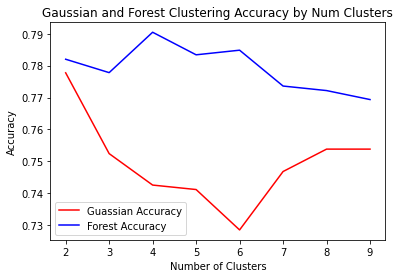

In [162]:
#Create a plot to show how the accuracy fluctuates with the number of clusters chosen for pre-processing

#Get the mean score for each n_clusters value used in the range provided earlier (2-10)
gaussian_cluster_mean_scores = gaussian_cluster_grid.cv_results_['mean_test_score']
forest_cluster_mean_scores = forest_cluster_grid.cv_results_['mean_test_score']

plt.plot(num_clusters, gaussian_cluster_mean_scores, 'r', label='Guassian Accuracy')
plt.plot(num_clusters, forest_cluster_mean_scores, 'b', label="Forest Accuracy")
plt.title('Gaussian and Forest Clustering Accuracy by Num Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Section 6: Generating True Test Predictions

Finally, I decided to generate label predictions for the actual test data from the Kaggle competition.

I submitted predictions from the Gradient Boosted Classification Tree, Gaussian NB Classifier, and the hyperparameter-tuned Neural Network.

In [18]:
#Read in the full set of training data
titanic_test_ds_full = pd.read_csv('./datasets/test.csv')
titanic_test_ds_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [78]:
#Clean the test set before generating predictions
titanic_test_ds_cleaned = titanic_test_ds_full.copy()

#Remove the one missing attributes
titanic_test_ds_cleaned = titanic_test_ds_cleaned.drop(['Name', 'PassengerId', 'Ticket'], axis=1)

#Map cabin values s.t. not having a cabin == 0 (False) and having a cabin == 1 (True)
titanic_test_ds_cleaned['Cabin']= np.where(titanic_test_ds_cleaned['Cabin'].isnull(), 0, 1)

titanic_test_ds_cleaned = data_pipeline.fit_transform(titanic_test_ds_cleaned)

In [104]:
import csv

#Isolate the passenger IDs from the Test dataset
passenger_ids = titanic_test_ds_full.PassengerId

#Function to create the csv of Survival predictions for submission
def write_predictions(passenger_predictions, filename='predictions.csv'):
    with open(filename, 'w') as fp:
        pred_writer = csv.writer(fp)
        pred_writer.writerow(['PassengerId', 'Survived'])
        pred_writer.writerows(passenger_predictions)

___
### SECTION 6B: Classifier Performance

In this section, predictions are generated for the three aforementioned classifiers. The performance of each classifier is shared towards the end as evaluated by the Kaggle competition.

#### Gradient-Boosting Classification Tree

In [105]:
#Make predictions on the dataset
gb_tree_predictions = gb_tree_clf.predict(titanic_test_ds_cleaned)

gb_tree_csv_predictions = []

for p_id, prediction in zip(passenger_ids, gb_tree_predictions):
    gb_tree_csv_predictions.append([p_id, prediction])
 
print("First five predictions:")
for i in range(5):
    print(gb_tree_csv_predictions[i][0], gb_tree_csv_predictions[i][1])

write_predictions(gb_tree_csv_predictions, "gradient_predictions.csv")

First five predictions:
892 0
893 0
894 0
895 0
896 0


#### Gaussian Naive Bayes

In [107]:
#Make predictions on the dataset
gaussian_predictions = gaussian_nb_clf.predict(titanic_test_ds_cleaned)

gaussian_csv_predictions = []

for p_id, prediction in zip(passenger_ids, gaussian_predictions):
    gaussian_csv_predictions.append([p_id, prediction])
    
print("First five predictions:")
for i in range(5):
    print(gaussian_csv_predictions[i][0], gaussian_csv_predictions[i][1])
    
write_predictions(gaussian_csv_predictions, "gaussian_predictions.csv")

First five predictions:
892 0
893 1
894 0
895 0
896 1


#### Deep Neural Network

In [128]:
#Make predictions on the dataset
nn_predictions = titanic_nn_tuned.predict(titanic_test_ds_cleaned)

nn_csv_predictions = []

for p_id, prediction in zip(passenger_ids, nn_predictions):
    
    #Convert probabilities to classifications (>0.5 = 1, else 0)
    if prediction > 0.5:
        prediction = 1
    else:
        prediction = 0 
    nn_csv_predictions.append([p_id, prediction])
    
print("First five predictions:")
for i in range(5):
    print(nn_csv_predictions[i][0], nn_csv_predictions[i][1])
    
write_predictions(nn_csv_predictions, "nn_predictions.csv")

First five predictions:
892 0
893 1
894 0
895 0
896 0


### Performance Reflections

After submitting all three sets of predictions, the best performing entry was the Artificial Neural Network used with hyper-parameter tuning. The prediction scores are below:

**Gradient Boosting Classification Tree:** 0.77033

**Gaussian Naive-Bayes:** 0.73205

**Deep Neural Network:** 0.77751

All of these scores are lower than those produced on the training/validation sets and my own testing set. This could indicate that each classifier is prone to some overfitting.

___
### SECTION 6C: Final Experiment: Dropout

Due to the possibility of overfitting in each of the classifiers used for the test set, I decided to conduct one final experiment to improve the test results. I created a new neural network using a Dropout layer and the best parameters decided in hyperparameter tuning from the Neural Network section earlier.

I first fit and train this new network on the training data, and then my own testing data.

At the end of this section I provide the Kaggle competition test performance score to see if this method had any noticeable improvement.

In [141]:
#Define the Neural Network Build function
#This function creates a Deep Sequential neural network with a Flattening layer, two Dense (Fully-connected) layers,
#and a final decision layer using the sigmoid activation function
def create_dropout_net():
    model_nn = models.Sequential()
    model_nn.add(layers.Flatten())
    model_nn.add(layers.Dense(32, activation='relu'))
    model_nn.add(layers.Dense(16, activation='relu'))
    model_nn.add(layers.Dropout(0.5))
    model_nn.add(layers.Dense(1, activation='sigmoid'))
    
    #Configure the network to use an RMSProp optimization function
    #The network measures loss using Binary Cross-entropy
    #The network measures its success in accuracy (ratio of correctly labeled data)
    model_nn.compile(optimizer='rmsprop', loss='binary_crossentropy', 
              metrics=['accuracy'])
    
    return model_nn

<!-- Based on these classification distribtuions and the performance of each classifier, I would summize that the Gaussian NB classifier had poor performance due to being overly optimistic about the number of predicted survivors in -->

In [142]:
dropout_nn = create_dropout_net()

In [144]:
history = dropout_nn.fit(titanic_train_flat, train_labels, epochs=nn_best_params['epochs'],
                   batch_size=nn_best_params['batch_size'], validation_split=0.25, verbose=0)

results = dropout_nn.evaluate(titanic_test_cleaned, test_labels)
print("Neural Network with Dropout Test Score " + "{:.6f}".format(results[1]))

6/6 [==============================] - 0s 2ms/step - loss: 0.4077 - accuracy: 0.8258
Neural Network with Dropout Test Score 0.825843


In [145]:
#Make predictions on the dataset
dropout_predictions = dropout_nn.predict(titanic_test_ds_cleaned)

dropout_csv_predictions = []

for p_id, prediction in zip(passenger_ids, dropout_predictions):
    
    #Convert probabilities to classifications (>0.5 = 1, else 0)
    if prediction > 0.5:
        prediction = 1
    else:
        prediction = 0 
    dropout_csv_predictions.append([p_id, prediction])
    
print("First five predictions:")
for i in range(5):
    print(dropout_csv_predictions[i][0], dropout_csv_predictions[i][1])
    
write_predictions(dropout_csv_predictions, "dropout_predictions.csv")

First five predictions:
892 0
893 0
894 0
895 0
896 0


#### Reflections

Unfortunately, the performance of this new neural network was only 0.77033 which is a slight fall from the original tuned neural network's performance.

Overfitting could still be an issue due to the decreased performance compared to my own training and test sets, but it's likely that more significant improvements would require more hyperparameter tuning or different manipulations of the initial dataset's features.

___
___
## SECTION 7: Concluding Thoughts

Overall, this was a very assignment to play around with. I learned a lot about what scikit-learn and Keras have to offer for machine learning tasks, and I felt that I got a better understanding of some of the key performance metrics for various classifiers.

My goal was to achieve 80% accuracy in the Kaggle competition, but I'm more than satisified with the performance of the classifiers I have now. Happy to have breached (at least for now) the top 5K submissions.

___
___

## SECTION 8: References + Extras

#### References Used

1. To complete this assignment, I made reference to the textbook linked below.
https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/

I did not copy code directly from this textbook, but did follow examples from various chapters in-order to complete this assignment.


2. I regularly referenced the websites:

https://scikit-learn.org/stable/
https://keras.io
https://numpy.org/doc/stable/
https://pandas.pydata.org/docs/

Again, in some cases I follow

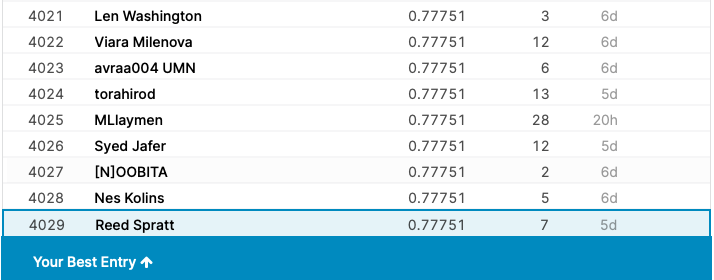

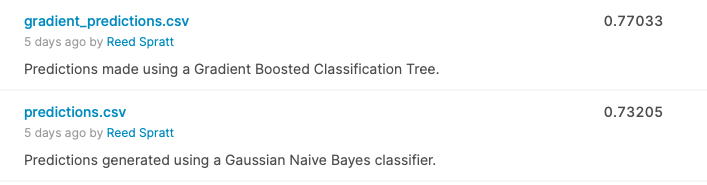

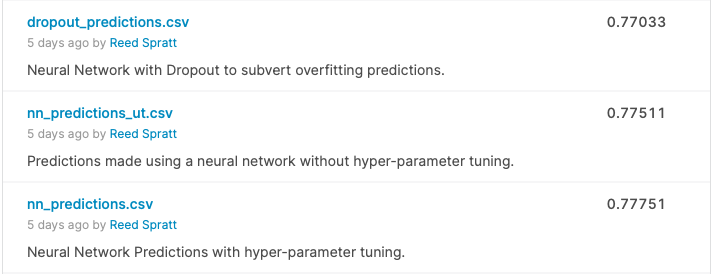